In [1]:
import sys
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedKFold

from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from tsfresh.feature_extraction import extract_features
from multiprocessing import Pool
tqdm.pandas(desc="apply progress")

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
data_dir = "/Users/hidehisa/.kaggle/competitions/plasticc"
train = pd.read_csv(data_dir + "/train_with_cluster.csv")
meta = pd.read_csv(data_dir + "/training_set_metadata.csv")

In [5]:
nova = [15, 42, 52, 62, 67, 90]
novaes = meta.query("target == @nova")
train_novae = train.query("object_id in @novaes.object_id")

In [6]:
train_novae.head()

,object_id,mjd,passband,flux,flux_err,detected,cluster
702,730,59798.3205,2,1.177371,1.364300,0,1
703,730,59798.3281,1,2.320849,1.159247,0,1
704,730,59798.3357,3,2.939447,1.771328,0,1
705,730,59798.3466,4,2.128097,2.610659,0,1
706,730,59798.3576,5,-12.809639,5.380097,0,1


In [216]:
def basic(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]

    aggs = {
        'flux': ['min', 'max', 'median', 'skew'],
        'detected': ['mean'],
        'flux_ratio_sq': ['sum', 'skew'],
        'flux_by_flux_ratio_sq': ['sum', 'skew'],
    }
    agg_df = df.groupby('object_id').agg(aggs)
    new_columns = [k + '_' + agg for k in aggs.keys() for agg in aggs[k]]
    agg_df.columns = new_columns
    agg_df['flux_diff'] = agg_df['flux_max'] - agg_df['flux_min']
    
    per_passband_aggs = {
        "flux": ["min", "max", "mean", "std"],
        "flux_ratio_sq": ["sum", "skew"],
        "flux_by_flux_ratio_sq": ["sum", "skew"]
    }
    per_pass_agg_df = df.groupby(["object_id", "passband"]).agg(per_passband_aggs)
    per_pass_agg_df.columns = pd.Index([e[0] + "_" + e[1] for e in per_pass_agg_df.columns])
    per_pass_agg_df["flux_diff"] = per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]
    per_pass_agg_df["flux_diff2"] = (
        per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_mean"]
    per_pass_agg_df["flux_w_mean"] = per_pass_agg_df["flux_by_flux_ratio_sq_sum"] / per_pass_agg_df[
        "flux_ratio_sq_sum"
    ]
    per_pass_agg_df["flux_dif3"] = (
    per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_w_mean"]
    per_pass_agg_df = per_pass_agg_df.unstack()
    per_pass_agg_df.columns = pd.Index([str(e[1]) + "__" + e[0] for e in per_pass_agg_df.columns])
    
    basic_columns = [f"{i}__{j}" for i in range(6) for j in [
        "flux_min",
        "flux_max",
        "flux_mean",
        "flux_std",
        "flux_ratio_sq_sum",
        "flux_ratio_sq_skew",
        "flux_w_mean",
        "flux_diff2"
    ]]
    per_pass_agg_df.drop(basic_columns, axis=1, inplace=True)
    
    agg_df = pd.merge(agg_df, per_pass_agg_df, how="left", on="object_id")
    
    agg_flux_diff = agg_df.reset_index()[["object_id", "flux_diff"]]
    df2 = pd.merge(df, agg_df, how="left", on="object_id")
    df2["flux_norm"] = df2.flux / df2.flux_diff
    del df2["flux"]
    agg_df.drop(["flux_min", "flux_max", "flux_diff"], axis=1, inplace=True)
    
    idxmax_df = df.reset_index().groupby("object_id").agg({"flux": "idxmax"})
    idxmax_df.rename(columns={"flux": "flux_idxmax"}, inplace=True)
    df3 = pd.merge(df, idxmax_df, how="left", on="object_id")
    df3.drop(["cluster", "flux_err", "detected"], axis=1, inplace=True)
    df3["dummy_index"] = df3.index
    df3["index_diff"] = df3.dummy_index - df3.flux_idxmax
    df3 = df3.query("index_diff >= 0 & index_diff < 100")
    df3_mindf = df3.groupby("object_id").agg({
        "flux": "min"
    })
    df3_mindf.rename(columns={"flux": "flux_min"}, inplace=True)
    df3 = pd.merge(df3, df3_mindf, how="left", on="object_id")
    df3["flux"] = df3["flux"] - df3["flux_min"]
    df3["log_flux"] = np.log(df3["flux"] + 0.01)
    fcp = {
        'fft_coefficient': [{
            'coeff': 0,
            'attr': 'abs'
        }, {
            'coeff': 1,
            'attr': 'abs'
        }],
        'kurtosis':
        None,
        'skewness':
        None,
        "cid_ce": [{"normalize": True}]
    }
    fcp2 = {
        "fft_coefficient": [{
            "coeff": 0,
            "attr": "abs"
        }, {
            "coeff": 1,
            "attr": "abs"
        }],
        "abs_energy": None,
        "sample_entropy": None
    }
    fcp3 = {
        "linear_trend": [{
            "attr": "pvalue"
        }, {
            "attr": "intercept"
        }, {
            "attr": "slope"
        }]
    }
    fcp_flux = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None,
        "mean_change": None,
        "mean_abs_change": None,
        "cid_ce": [{"normalize": True}]
    }
    fcp_flux_by_flux_ratio_sq = {
        "longest_strike_above_mean": None,
        "longest_strike_below_mean": None
    }
    agg_df_ts = extract_features(
        df,
        column_id='object_id',
        column_sort='mjd',
        column_kind='passband',
        column_value='flux',
        default_fc_parameters=fcp,
        n_jobs=6)
    agg_df_ts2 = extract_features(
        df2,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="flux_norm",
        default_fc_parameters=fcp2,
        n_jobs=4
    )
    agg_df_ts3 = extract_features(
        df3,
        column_id="object_id",
        column_sort="mjd",
        column_kind="passband",
        column_value="log_flux",
        default_fc_parameters=fcp3,
        n_jobs=4
    )
    agg_df_flux = extract_features(
        df,
        column_id="object_id",
        column_value="flux",
        default_fc_parameters=fcp_flux,
        n_jobs=4
    )
    agg_df_ffrs = extract_features(
        df,
        column_id="object_id",
        column_value="flux_by_flux_ratio_sq",
        default_fc_parameters=fcp_flux_by_flux_ratio_sq,
        n_jobs=4
    )
    df_det = df[df['detected'] == 1].copy()

    agg_df_mjd = extract_features(
        df_det,
        column_id='object_id',
        column_value='mjd',
        default_fc_parameters={
            'maximum': None,
            'minimum': None
        },
        n_jobs=8)
    agg_df_mjd['mjd_diff_det'] = agg_df_mjd['mjd__maximum'] - agg_df_mjd[
        'mjd__minimum']
    del agg_df_mjd['mjd__maximum'], agg_df_mjd['mjd__minimum']
    agg_df_ts2.columns = pd.Index([e + "_norm" for e in agg_df_ts2.columns])
    agg_df_ts = pd.merge(agg_df_ts, agg_df_mjd, on='id')
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts2, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ts3, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_flux, on="id")
    agg_df_ts = pd.merge(agg_df_ts, agg_df_ffrs, on="id")
    # tsfresh returns a dataframe with an index name='id'
    agg_df_ts.index.rename('object_id', inplace=True)
    agg_df = pd.merge(agg_df, agg_df_ts, on='object_id')
    return agg_df


def cluster_mean_diff(df):
    new_df = df.groupby(["object_id", "cluster"]).agg({
        "flux": ["mean", "max", "min"]
    })
    new_df.columns = pd.Index(
        [e[0] + "_" + e[1] for e in new_df.columns.tolist()])
    new_df["normalized_mean"] = new_df["flux_mean"] / (
        new_df["flux_max"] - new_df["flux_min"])
    new_df.reset_index(inplace=True)
    return new_df.groupby("object_id").agg({"normalized_mean": "std"})


def passband_std_difference(df):
    std_df = df.groupby(["object_id", "cluster", "passband"]).agg({
        "flux": "std"
    }).reset_index().groupby(["object_id",
                              "passband"])["flux"].mean().reset_index()
    std_df_max = std_df.groupby("object_id")["flux"].max()
    std_df_min = std_df.groupby("object_id")["flux"].min()
    return (std_df_max / std_df_min).reset_index()


def num_outliers(df):
    new_df = df.groupby("object_id").agg({"flux": ["mean", "std"]})
    new_df.columns = pd.Index([e[0] + "_" + e[1] for e in new_df.columns])
    new_df["upper_sigma"] = new_df["flux_mean"] + new_df["flux_std"]
    new_df["upper_2sigma"] = new_df["flux_mean"] + 2 * new_df["flux_std"]
    new_df["lower_sigma"] = new_df["flux_mean"] - new_df["flux_std"]
    new_df["lower_2sigma"] = new_df["flux_mean"] - 2 * new_df["flux_std"]
    new_df.drop(["flux_mean", "flux_std"], axis=1, inplace=True)
    new_df = pd.merge(df, new_df, how="left", on="object_id")
    new_df["outside_sigma"] = (
        (new_df["flux"] > new_df["upper_sigma"]) |
        (new_df["flux"] < new_df["lower_sigma"])).astype(int)
    new_df["outside_2sigma"] = (
        (new_df["flux"] > new_df["upper_2sigma"]) |
        (new_df["flux"] < new_df["lower_2sigma"])).astype(int)

    return_df = new_df.groupby("object_id").agg({
        "outside_sigma": "sum",
        "outside_2sigma": "sum"
    })
    return_df.reset_index(inplace=True)
    return return_df

In [205]:
def haversine_plus(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees) from 
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """
    #Convert decimal degrees to Radians:
    lon1 = np.radians(lon1)
    lat1 = np.radians(lat1)
    lon2 = np.radians(lon2)
    lat2 = np.radians(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    dlat = np.subtract(lat2, lat1)

    a = np.add(np.power(np.sin(np.divide(dlat, 2)), 2),  
                          np.multiply(np.cos(lat1), 
                                      np.multiply(np.cos(lat2), 
                                                  np.power(np.sin(np.divide(dlon, 2)), 2))))
    
    haversine = np.multiply(2, np.arcsin(np.sqrt(a)))
    return {
        'haversine': haversine, 
        'latlon1': np.subtract(np.multiply(lon1, lat1), np.multiply(lon2, lat2)), 
   }


def process_meta(meta_df):
    meta_dict = dict()
    # distance
    meta_dict.update(haversine_plus(meta_df['ra'].values, meta_df['decl'].values, 
                   meta_df['gal_l'].values, meta_df['gal_b'].values))
    #
    meta_dict['hostgal_photoz_certain'] = np.multiply(
            meta_df['hostgal_photoz'].values, 
             np.exp(meta_df['hostgal_photoz_err'].values))
    
    meta_df = pd.concat([meta_df, pd.DataFrame(meta_dict, index=meta_df.index)], axis=1)
    return meta_df


def add_rank_bottom_and_top(df, feature_name):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial = df[objid+columns]
    partial_values = partial.melt(id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])
    
    top_and_bottom = partial_values.groupby("object_id").agg({
        "variable": ["first", "last"]
    })
    top_and_bottom.columns = ["top"+feature_name, "bottom"+feature_name]
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        top_and_bottom = top_and_bottom.replace(n, i)
    top_and_bottom = top_and_bottom.astype(int)
    return top_and_bottom



def rank(df, feature_name, thres=20):
    objid = ["object_id"]
    columns = [f"{i}{feature_name}" for i in range(6)]
    partial = df[objid+columns]
    partial_values = partial.melt(id_vars=objid, value_vars=columns).sort_values(["object_id", "value"])
    for i, n in zip(["0", "1", "2", "3", "4", "5"], columns):
        partial_values.replace(n, i, inplace=True)
    partial_values["dummy"] = 1
    rank_feats = partial_values.groupby(["object_id", "dummy"]).agg({
        "variable": "sum"
    })
    d = dict()
    cnt = 0
    for i in rank_feats["variable"]:
        if i not in d.keys():
            d[i] = cnt
            cnt += 1
    rank_feats.reset_index(inplace=True)
    rank_feats.drop("dummy", axis=1, inplace=True)
    rank_feats.rename(columns={"variable": f"rank{feature_name}"}, inplace=True)
    rank_feats[f"rank{feature_name}"].replace(d, inplace=True)
    rank_dict = (rank_feats[f"rank{feature_name}"].value_counts() > thres).to_dict()
    rank_feats[f"rank{feature_name}"] = rank_feats[f"rank{feature_name}"].map(
        lambda x: x if rank_dict[x] else cnt+1
    )
    
    return rank_feats



def add_by_features(df, feature_name, new_feat_name):
    for i in range(5):
        for j in range(1, 6):
            if j > i:
                df[f"{new_feat_name}{j}_by_{i}"] = df[f"{j}{feature_name}"] / df[f"{i}{feature_name}"]
    return df


In [206]:
def add_per_passband(d):
    df = d.copy()
    df["flux_ratio_sq"] = np.power(df["flux"] / df["flux_err"], 2)
    df["flux_by_flux_ratio_sq"] = df["flux"] * df["flux_ratio_sq"]
    per_passband_aggs = {
        "flux": ["min", "max", "mean", "std"],
        "flux_ratio_sq": ["sum", "skew"],
        "flux_by_flux_ratio_sq": ["sum", "skew"]
    }
    per_pass_agg_df = df.groupby(["object_id", "passband"]).agg(per_passband_aggs)
    per_pass_agg_df.columns = pd.Index([e[0] + "_" + e[1] for e in per_pass_agg_df.columns])
    per_pass_agg_df["flux_diff"] = per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]
    per_pass_agg_df["flux_diff2"] = (
        per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_mean"]
    per_pass_agg_df["flux_w_mean"] = per_pass_agg_df["flux_by_flux_ratio_sq_sum"] / per_pass_agg_df[
        "flux_ratio_sq_sum"
    ]
    per_pass_agg_df["flux_dif3"] = (
    per_pass_agg_df["flux_max"] - per_pass_agg_df["flux_min"]) / per_pass_agg_df["flux_w_mean"]
    per_pass_agg_df = per_pass_agg_df.unstack()
    per_pass_agg_df.columns = pd.Index([str(e[1]) + "__" + e[0] for e in per_pass_agg_df.columns])
    basic_columns = [f"{i}__{j}" for i in range(6) for j in [
        "flux_min",
        "flux_max",
        "flux_mean",
        "flux_std",
        "flux_ratio_sq_sum",
        "flux_ratio_sq_skew",
        "flux_w_mean",
        "flux_diff2"
    ]]
    per_pass_agg_df.drop(basic_columns, axis=1, inplace=True)
    return per_pass_agg_df

In [239]:
def get_full(df, meta):
    agg_basic = basic(df)
    cl_mean_diff = cluster_mean_diff(df)
    ps_std_diff = passband_std_difference(df)
    num_out = num_outliers(df)

    full = pd.merge(agg_basic, cl_mean_diff, how="left", on="object_id")
    full = pd.merge(full, ps_std_diff, how="left", on="object_id")
    full = pd.merge(full, num_out, how="left", on="object_id")
    meta = process_meta(meta)
    full = pd.merge(full, meta, how="left", on="object_id")
    
    add_by_features(full, "__abs_energy_norm", "abs_energy")
    add_by_features(full, "__flux_diff", "flux_diff")
    add_by_features(full, "__flux_dif3", "flux_dif3")
    add_by_features(full, "__flux_by_flux_ratio_sq_sum", "flux_by_flux_ratio_sq_sum")
    add_by_features(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm", "fft")
    add_by_features(full, "__linear_trend__attr_\"pvalue\"", "linear_p")
    add_by_features(full, "__linear_trend__attr_\"intercept\"", "linear_i")
    add_by_features(full, "__linear_trend__attr_\"slope\"", "linear_s")
    
    abs_energy = add_rank_bottom_and_top(full, "__abs_energy_norm")
    rank_abs_energy = rank(full, "__abs_energy_norm", 70)

    flux_diff = add_rank_bottom_and_top(full, "__flux_diff")
    rank_flux_diff = rank(full, "__flux_diff", 70)

    flux_dif3 = add_rank_bottom_and_top(full, "__flux_dif3")
    rank_flux_dif3 = rank(full, "__flux_dif3", 70)

    flux_by_flux_ratio_sq_sum = add_rank_bottom_and_top(full, "__flux_by_flux_ratio_sq_sum")
    rank_flux_by_flux_ratio_sq_sum = rank(full, "__flux_by_flux_ratio_sq_sum", 70)
    
    fc = add_rank_bottom_and_top(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm")
    rank_fc = rank(full, "__fft_coefficient__coeff_0__attr_\"abs\"_norm", 70)
    
    linear_p = add_rank_bottom_and_top(full, "__linear_trend__attr_\"pvalue\"")
    rank_linear_p = rank(full, "__linear_trend__attr_\"pvalue\"", 70)
    
    linear_i = add_rank_bottom_and_top(full, "__linear_trend__attr_\"intercept\"")
    rank_linear_i = rank(full, "__linear_trend__attr_\"intercept\"", 70)
    
    linear_s = add_rank_bottom_and_top(full, "__linear_trend__attr_\"slope\"")
    rank_linear_s = rank(full, "__linear_trend__attr_\"slope\"", 70)
    full = pd.merge(full, rank_abs_energy, how="left", on="object_id")
    full = pd.merge(full, rank_flux_diff, how="left", on="object_id")
    full = pd.merge(full, rank_flux_dif3, how="left", on="object_id")
    full = pd.merge(full, abs_energy, how="left", on="object_id")
    full = pd.merge(full, flux_diff, how="left", on="object_id")
    full = pd.merge(full, flux_dif3, how="left", on="object_id")
    full = pd.merge(full, flux_by_flux_ratio_sq_sum, how="left", on="object_id")
    full = pd.merge(full, rank_flux_by_flux_ratio_sq_sum, how="left", on="object_id")
    full = pd.merge(full, fc, how="left", on="object_id")
    full = pd.merge(full, rank_fc, how="left", on="object_id")
    full = pd.merge(full, linear_p, how="left", on="object_id")
    full = pd.merge(full, rank_linear_p, how="left", on="object_id")
    full = pd.merge(full, linear_i, how="left", on="object_id")
    full = pd.merge(full, rank_linear_i, how="left", on="object_id")
    full = pd.merge(full, linear_s, how="left", on="object_id")
    full = pd.merge(full, rank_linear_s, how="left", on="object_id")
    if "target" in full.columns:
        full.drop("target", axis=1, inplace=True)
    return full


def train_data(df, meta):
    full = get_full(df, meta)
    y = meta.target
    classes = sorted(y.unique())
    class_weight = {c: 1 for c in classes}

    for c in [15]:
        class_weight[c] = 2
    oof_df = full[["object_id"]]
    del full['object_id'], full['distmod'], full['hostgal_specz']
    del full['ra'], full['decl'], full['gal_l'], full['gal_b'], full['ddf']
    return full, y, classes, class_weight, oof_df

In [240]:
%%time
full, y, classes, class_weight, oof_df = train_data(train_novae, novaes)

Feature Extraction: 100%|██████████| 40/40 [00:00<00:00, 101.57it/s]


CPU times: user 52 s, sys: 4.91 s, total: 56.9 s
Wall time: 1min 3s


In [241]:
classes

[15, 42, 52, 62, 67, 90]

In [242]:
class_weight

{15: 2, 42: 1, 52: 1, 62: 1, 67: 1, 90: 1}

In [243]:
train_mean = full.mean(axis=0)
full.replace([np.inf, -np.inf], np.nan, inplace=True)
full.fillna(0, inplace=True)
full.head()

,flux_median,flux_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,0__flux_by_flux_ratio_sq_sum,1__flux_by_flux_ratio_sq_sum,2__flux_by_flux_ratio_sq_sum,...,"rank__fft_coefficient__coeff_0__attr_""abs""_norm","top__linear_trend__attr_""pvalue""","bottom__linear_trend__attr_""pvalue""","rank__linear_trend__attr_""pvalue""","top__linear_trend__attr_""intercept""","bottom__linear_trend__attr_""intercept""","rank__linear_trend__attr_""intercept""","top__linear_trend__attr_""slope""","bottom__linear_trend__attr_""slope""","rank__linear_trend__attr_""slope"""
0,0.409172,3.177854,0.069697,4124.451516,5.480405,1.046502e+05,5.989138,2.274455e+00,2.032471e+01,2.042918e+04,...,0,2,0,644,0,5,0,5,0,0
1,1.035895,4.979826,0.173789,94161.650792,9.611274,1.439125e+07,11.141069,4.016307e+03,3.510925e+06,5.506723e+06,...,1,3,0,644,0,3,1,4,0,634
2,1.141288,4.406298,0.173295,34324.179753,7.868462,3.015599e+06,7.908174,1.048432e+02,5.897740e+04,1.132796e+06,...,2,3,0,2,0,4,563,5,0,0
3,0.337299,6.278757,0.056818,285735.477529,6.381754,2.707323e+08,7.086625,4.949848e+06,7.693326e+07,8.285281e+07,...,510,0,5,3,0,5,0,0,5,2
4,0.623454,2.486305,0.008523,699.287831,4.861840,5.470282e+03,6.580398,5.630962e+01,3.162745e+01,2.829888e+01,...,0,4,0,4,0,5,0,3,0,634


In [26]:
def multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [15, 42, 52, 62, 67, 90]
    class_weight = {
        15: 2,
        42: 1,
        52: 1,
        62: 1,
        67: 1,
        90: 1,
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds
    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return loss


def lgb_multi_weighted_logloss_novae(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    # class_weights taken from Giba's topic : https://www.kaggle.com/titericz
    # https://www.kaggle.com/c/PLAsTiCC-2018/discussion/67194
    # with Kyle Boone's post https://www.kaggle.com/kyleboone
    classes = [15, 42, 52, 62, 67, 90]
    class_weight = {
        15: 2,
        42: 1,
        52: 1,
        62: 1,
        67: 1,
        90: 1,
    }
    if len(np.unique(y_true)) > 14:
        classes.append(99)
        class_weight[99] = 2
    y_p = y_preds.reshape(y_true.shape[0], len(classes), order='F')

    # Trasform y_true in dummies
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1 - 1e-15)
    # Transform to log
    y_p_log = np.log(y_p)
    # Get the log for ones, .values is used to drop the index of DataFrames
    # Exclude class 99 for now, since there is no class99 in the training set
    # we gave a special process for that class
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array(
        [class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos

    loss = -np.sum(y_w) / np.sum(class_arr)
    return 'wloss', loss, False

In [90]:
def save_importances(importances_):
    mean_gain = importances_[['gain', 'feature']].groupby('feature').mean()
    importances_['mean_gain'] = importances_['feature'].map(mean_gain['gain'])
    plt.figure(figsize=(8, 12))
    sns.barplot(
        x='gain',
        y='feature',
        data=importances_.sort_values('mean_gain', ascending=False)[:300])
    plt.tight_layout()
    plt.savefig('importances_novae.png')


def plot_confusion_matrix(cm,
                          classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j,
            i,
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


def save_cm(y, oof_preds):
    unique_y = np.unique(y)
    class_map = dict()
    for i, val in enumerate(unique_y):
        class_map[val] = i

    y_map = np.zeros((y.shape[0], ))
    y_map = np.array([class_map[val] for val in y])

    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_map, np.argmax(oof_preds, axis=-1))
    np.set_printoptions(precision=2)

    class_names = ["class_15", "class_42", "class_52", "class_62", "class_67", "class_90"]
    # Plot non-normalized confusion matrix
    plt.figure(figsize=(12, 12))
    plot_confusion_matrix(
        cnf_matrix,
        classes=class_names,
        normalize=True,
        title='Confusion matrix')
    plt.savefig("confusion_matrix_novae.png")

In [15]:
def smoteAdataset(Xig_train, yig_train, Xig_test, yig_test):     
    sm=SMOTE(random_state=2)
    Xig_train_res, yig_train_res = sm.fit_sample(Xig_train, yig_train.ravel())
    return Xig_train_res, pd.Series(yig_train_res), Xig_test, pd.Series(yig_test)

In [230]:
def lgbm_modeling_cross_validation(params,
                                   full_train, 
                                   y, 
                                   classes, 
                                   class_weights, 
                                   nr_fold=12, 
                                   random_state=1):

    # Compute weights
    w = y.value_counts()
    weights = {i : np.sum(w) / w[i] for i in w.index}
   # print(weights)
   # weights=class_weights
    clfs = []
    importances = pd.DataFrame()
    folds = StratifiedKFold(n_splits=nr_fold, 
                            shuffle=True, 
                            random_state=random_state)
    
    oof_preds = np.zeros((len(full_train), np.unique(y).shape[0]))
    for fold_, (trn_, val_) in enumerate(folds.split(y, y)):
        trn_x, trn_y = full_train.iloc[trn_], y.iloc[trn_]
        val_x, val_y = full_train.iloc[val_], y.iloc[val_]
        
                
        trn_xa, trn_y, val_xa, val_y=smoteAdataset(trn_x.values, trn_y.values, val_x.values, val_y.values)
        trn_x=pd.DataFrame(data=trn_xa, columns=trn_x.columns)
    
        val_x=pd.DataFrame(data=val_xa, columns=val_x.columns)
        
        clf = lgb.LGBMClassifier(**params)
        clf.fit(
            trn_x, trn_y,
            eval_set=[(trn_x, trn_y), (val_x, val_y)],
            eval_metric=lgb_multi_weighted_logloss_novae,
            verbose=100,
            early_stopping_rounds=50,
            sample_weight=trn_y.map(weights),
            categorical_feature=[
                "rank__abs_energy_norm",
                "rank__flux_diff",
                "rank__flux_dif3",
                "rank__flux_by_flux_ratio_sq_sum",
                "rank__fft_coefficient__coeff_0__attr_\"abs\"_norm",
                "rank__linear_trend__attr_\"pvalue\"",
                "rank__linear_trend__attr_\"intercept\"",
                "rank__linear_trend__attr_\"slope\""
            ]
        )
        clfs.append(clf)

        oof_preds[val_, :] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)
        print('no {}-fold loss: {}'.format(fold_ + 1, 
              multi_weighted_logloss_novae(val_y, oof_preds[val_, :])))
    
        imp_df = pd.DataFrame({
                'feature': full_train.columns,
                'gain': clf.feature_importances_,
                'fold': [fold_ + 1] * len(full_train.columns),
                })
        importances = pd.concat([importances, imp_df], axis=0, sort=False)

    score = multi_weighted_logloss_novae(y_true=y, y_preds=oof_preds)
    print('MULTI WEIGHTED LOG LOSS: {:.5f}'.format(score))
    df_importances = save_importances(importances_=importances)
    
    return clfs, score, oof_preds

In [248]:
lgb_params = {
        'device': 'cpu', 
        'objective': 'binary',  
        'boosting_type': 'gbdt', 
        'n_jobs': -1, 
        'max_depth': 7, 
        'n_estimators': 500, 
        'subsample_freq': 2, 
        'subsample_for_bin': 5000, 
        'min_data_per_group': 100, 
        'max_cat_to_onehot': 4, 
        'cat_l2': 1.0, 
        'cat_smooth': 59.5, 
        'max_cat_threshold': 32, 
        'metric_freq': 10, 
        'verbosity': -1, 
        'metric': 'binary', 
        'xgboost_dart_mode': False, 
        'uniform_drop': False, 
        'colsample_bytree': 0.5, 
        'drop_rate': 0.173, 
        'learning_rate': 0.0267, 
        'max_drop': 5, 
        'min_child_samples': 10, 
        'min_child_weight': 100.0, 
        'min_split_gain': 0.1, 
        'num_leaves': 7, 
        'reg_alpha': 0.1, 
        'reg_lambda': 0.00023, 
        'skip_drop': 0.44, 
        'subsample': 0.75
    }

novae_params = {
    'device': 'cpu', 
    'objective': 'multiclass', 
    'num_class': 5, 
    'boosting_type': 'gbdt', 
    'n_jobs': -1, 
    'max_depth': 4,
    'n_estimators': 500,
    'num_leaves': 6,
    'learning_rate': 0.11,
    'drop_rate': 0.08,
    'subsample': 0.75,
    'subsample_freq': 2,
    'min_split_gain': 0.1,
    'max_cat_to_onehot': 4, 
    'cat_l2': 1.0, 
    'cat_smooth': 59.5
}

/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.318229	training's wloss: 0.54299	valid_1's multi_logloss: 1.24854	valid_1's wloss: 1.09375
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.291498	training's wloss: 0.504353	valid_1's multi_logloss: 1.2163	valid_1's wloss: 1.08717
no 1-fold loss: 1.0871716113710126


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.312363	training's wloss: 0.538182	valid_1's multi_logloss: 1.22989	valid_1's wloss: 1.11295
Early stopping, best iteration is:
[111]	training's multi_logloss: 0.287693	training's wloss: 0.500478	valid_1's multi_logloss: 1.19014	valid_1's wloss: 1.10766
no 2-fold loss: 1.107658591736195


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.322952	training's wloss: 0.551143	valid_1's multi_logloss: 1.29094	valid_1's wloss: 1.04532
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.248776	training's wloss: 0.44038	valid_1's multi_logloss: 1.1716	valid_1's wloss: 1.02951
no 3-fold loss: 1.0295117357009897


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.327429	training's wloss: 0.555416	valid_1's multi_logloss: 1.28459	valid_1's wloss: 1.08907
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.251172	training's wloss: 0.439264	valid_1's multi_logloss: 1.1612	valid_1's wloss: 1.0651
no 4-fold loss: 1.0650966111557671


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/hidehisa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1188: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['rank__abs_energy_norm', 'rank__fft_coefficient__coeff_0__attr_"abs"_norm', 'rank__flux_by_flux_ratio_sq_sum', 'rank__flux_dif3', 'rank__flux_diff', 'rank__linear_trend__attr_"intercept"', 'rank__linear_trend__attr_"pvalue"', 'rank__linear_trend__attr_"slope"']
  'New categorical_feature is {}'.format(sorted(list(categorical_feat

Training until validation scores don't improve for 50 rounds.
[100]	training's multi_logloss: 0.322209	training's wloss: 0.545852	valid_1's multi_logloss: 1.29655	valid_1's wloss: 1.10998
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.244994	training's wloss: 0.431758	valid_1's multi_logloss: 1.18659	valid_1's wloss: 1.10056
no 5-fold loss: 1.1005608006568017
MULTI WEIGHTED LOG LOSS: 1.07787


/Users/hidehisa/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


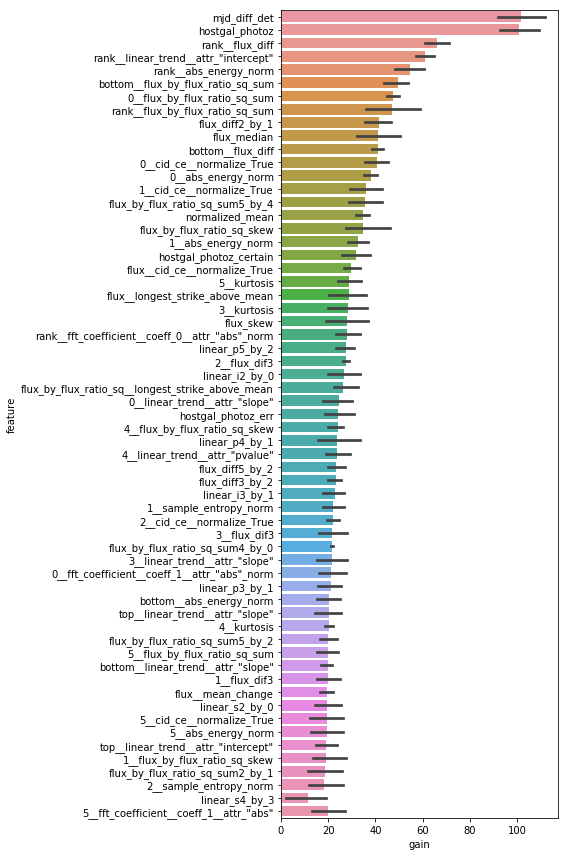

In [249]:
for cindex in full.columns:
    full.loc[:,cindex]=np.float64(full.loc[:,cindex])
clfs, score, oof_df = lgbm_modeling_cross_validation(
    novae_params, 
    full, 
    y, 
    classes,
    class_weight,
    5,
    7)

Normalized confusion matrix


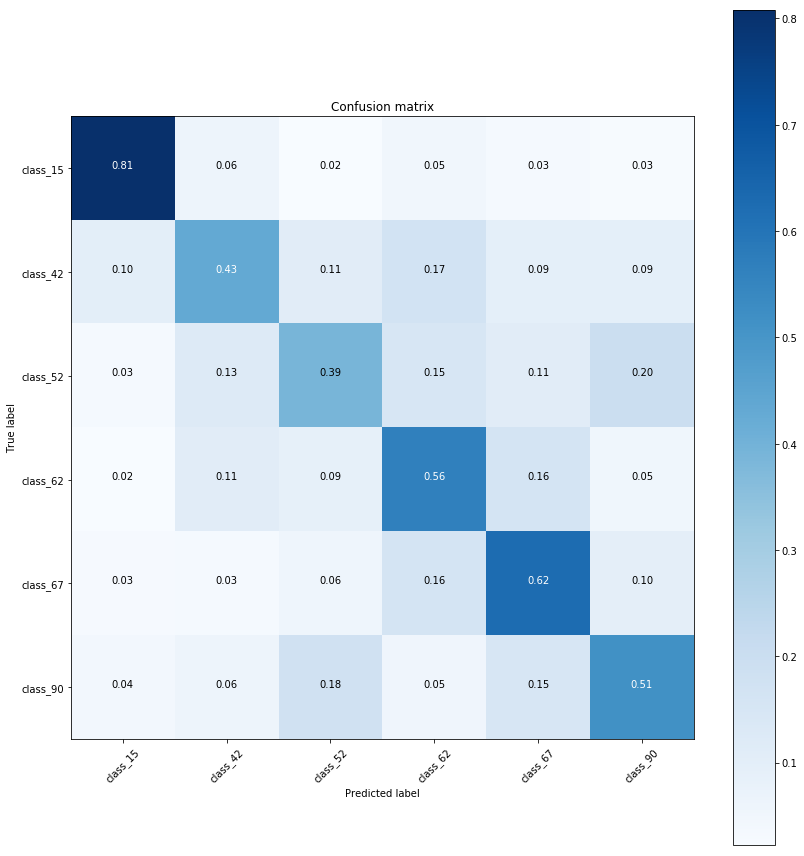

In [250]:
save_cm(y, oof_df)